## Import libraries and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import optuna

import sys
sys.path.append("..")

from preprocessing.data_augmentor import DataAugmentor
from preprocessing.feature_extractor import FeatureExtractor
from preprocessing.sampler import Sampler

## Data Preprocessing

In [2]:
import os
print(os.getcwd())

data_dir = "../data/Composer_Dataset"
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
scalar_features, multidimensional_features = FeatureExtractor.extract_features_for_directory(data_dir, composers)

C:\Users\sassy\OneDrive\Documents\GitHub\ms-aai-511-final-project\src
Loading existing features from ../data/Composer_Dataset\extracted_features.pkl


In [3]:
scalar_features.head()

,max_independent_voices,avg_independent_voices,var_independent_voices,avg_simultaneity,var_simultaneity,note_density,avg_note_duration,var_note_duration,initial_tempo,time_signature_numerator,...,perfect_vertical_intervals,vertical_minor_seconds,vertical_thirds,vertical_fifths,vertical_tritones,vertical_octaves,avg_chord_duration,length,file_name,composer
0,4.0,3.868889,0.337522,3.829787,0.807390,6.755565,0.592104,0.341892,184.000258,4.0,...,0.401902,0.002774,0.311138,0.168450,0.030123,0.124059,0.441176,46.956456,003706b_.mid,Bach
1,4.0,3.920000,0.271293,4.000000,0.000000,5.622222,0.711462,0.341781,109.714286,4.0,...,0.408951,0.002315,0.339506,0.179784,0.035880,0.137731,0.576923,45.000000,003806b_.mid,Bach
2,4.0,3.943529,0.230828,4.000000,0.000000,6.705882,0.596491,0.254569,140.800000,4.0,...,0.414447,0.002421,0.301049,0.168684,0.033091,0.144471,0.456989,42.500000,003907bv.mid,Bach
3,4.0,3.943529,0.230828,4.000000,0.000000,6.705882,0.596491,0.254569,140.800000,4.0,...,0.414447,0.002421,0.301049,0.168684,0.033091,0.144471,0.456989,42.500000,003907b_.mid,Bach
4,4.0,3.893238,0.308810,3.746667,0.974246,7.253333,0.551471,0.186561,147.692308,4.0,...,0.375940,0.005639,0.332707,0.168546,0.052005,0.115288,0.419403,30.000000,004003b_.mid,Bach


In [4]:
print(f"Piano Roll Shape: {multidimensional_features[0]['piano_roll'].shape}")
print(f"Chroma Piano Roll Shape: {multidimensional_features[0]['chroma_piano_roll'].shape}")
print(f"Pitch Class Histogram Shape: {multidimensional_features[0]['pitch_class_histogram'].shape}")
print(f"Pitch Class Transition Matrix Shape: {multidimensional_features[0]['pitch_class_transition_matrix'].shape}")

Piano Roll Shape: (128, 469)
Chroma Piano Roll Shape: (12, 469)
Pitch Class Histogram Shape: (12,)
Pitch Class Transition Matrix Shape: (12, 12)


# Train Test Split Validation

In [6]:
y = scalar_features['composer']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

scalar_train, scalar_holdout, multidim_train, multidim_holdout, y_train, y_holdout = Sampler.split_data(scalar_features, multidimensional_features, y, test_size=0.2, random_state=1)

scalar_val, scalar_test, multidim_val, multidim_test, y_val, y_test = Sampler.split_data(scalar_holdout, multidim_holdout, y_holdout, test_size=0.5, random_state=1)

train_composer_files = scalar_train[['composer', 'file_name']]
scalar_features = scalar_features.drop('file_name', axis=1)
scalar_train.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)

C:\Users\sassy\AppData\Local\Temp\ipykernel_10896\2216297816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
C:\Users\sassy\AppData\Local\Temp\ipykernel_10896\2216297816.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)


{'Bach': 815, 'Mozart': 215, 'Beethoven': 176, 'Chopin': 102}


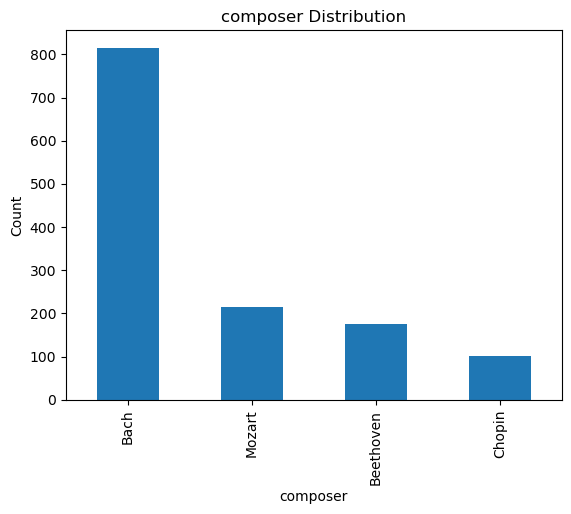

In [7]:
def plot_column_distribution(data: pd.DataFrame, column: str) -> None:
    print(dict(data[column].value_counts()))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'{column} Distribution')
    plt.xlabel(f'{column}')
    plt.ylabel(f'Count')
    plt.show()
    
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

{'Mozart': 815, 'Bach': 815, 'Beethoven': 815, 'Chopin': 815}


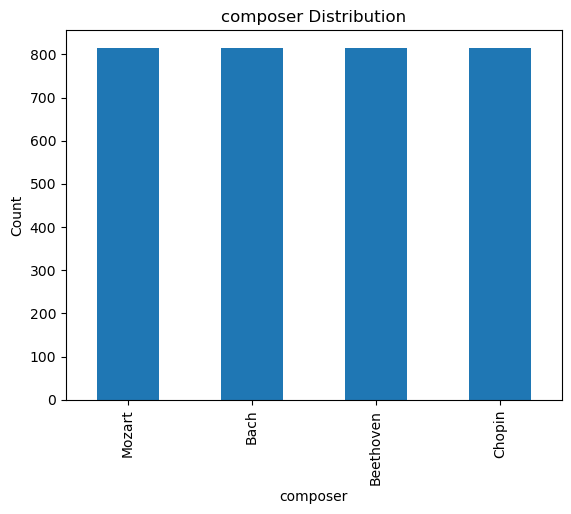

In [8]:
scalar_train, multidim_train, y_train = Sampler.oversample_balance(scalar_train, multidim_train, y_train)
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

In [9]:
num_augmented_songs = 100
mozart_aug_scalars, mozart_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Mozart'], num_augmented_songs)
bach_aug_scalars, bach_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Bach'], num_augmented_songs)
beethoven_aug_scalars, beethoven_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Beethoven'], num_augmented_songs)
chopin_aug_scalars, chopin_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Chopin'], num_augmented_songs)

scalar_train = pd.concat([scalar_train, mozart_aug_scalars, bach_aug_scalars, beethoven_aug_scalars, chopin_aug_scalars], axis=0)
multidim_train = multidim_train + mozart_aug_multidim + bach_aug_multidim + beethoven_aug_multidim + chopin_aug_multidim

Generating Augmented Songs:  11%|█████▌                                             | 11/100 [00:53<07:39,  5.17s/song]C:\Users\sassy\anaconda3\Lib\site-packages\numpy\lib\histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
Generating Augmented Songs:  29%|██████████████▊                                    | 29/100 [02:07<02:05,  1.77s/song]C:\Users\sassy\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Generating Augmented Songs:  77%|███████████████████████████████████████▎           | 77/100 [00:31<00:21,  1.05song/s]C:\Users\sassy\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signatu

In [10]:
mozart_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Mozart']))
bach_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Bach']))
beethoven_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Beethoven']))
chopin_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Chopin']))
y_train = np.hstack((y_train, mozart_aug_y, bach_aug_y, beethoven_aug_y, chopin_aug_y))

{'Mozart': 915, 'Bach': 915, 'Beethoven': 915, 'Chopin': 915}


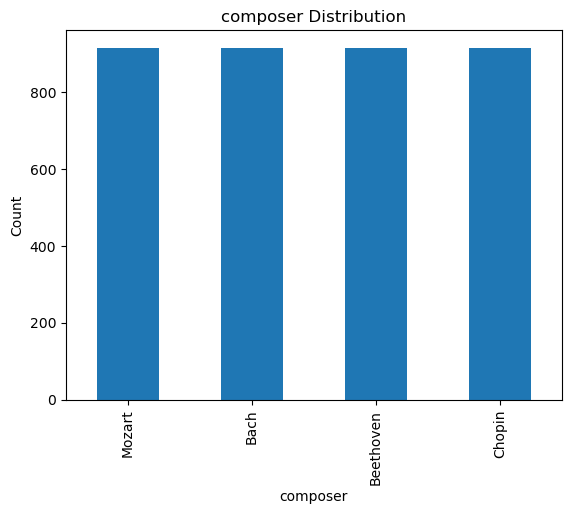

In [11]:
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

### Chunk Into Sequences

In [47]:
def chunk_sequences(X_in, y_in, feature, sequence_length=100):
    X_out = []
    y_out = []

    # Make sure you are slicing along the time axis
    for i in range(len(X_in)):
        feature_matrix = X_in[i][feature]
        num_time_steps = feature_matrix.shape[1]
        
        for j in range(0, num_time_steps - sequence_length, sequence_length):
            X_out.append(feature_matrix[:, j:j + sequence_length].T)  # Transpose to (sequence_length, feature_dim)
            y_out.append(y_in[i])

    return X_out, y_out

### Make Dataloader

PyTorch utilized for laoding, training, and evlation of LSTM model.

In [50]:
class PianoRollDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32) 
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y

In [52]:
def get_dataloaders(use_chroma, seq_length=100, batch_size=8):
    
    # Set random seed for PyTorch
    torch.manual_seed(42) 
    
    feature_set = 'chroma_piano_roll' if use_chroma else 'piano_roll'

    X_train_seq, y_train_seq = chunk_sequences(multidim_train, y_train, feature_set, seq_length)
    X_val_seq, y_val_seq = chunk_sequences(multidim_val, y_val, feature_set, seq_length)
    X_test_seq, y_test_seq = chunk_sequences(multidim_test, y_test, feature_set, seq_length)

    train_dataset = PianoRollDataset(X_train_seq, y_train_seq)
    val_dataset = PianoRollDataset(X_val_seq, y_val_seq)
    test_dataset = PianoRollDataset(X_test_seq, y_test_seq)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

### Define LSTM

Long short-term memory is a type of recurrent neural network aimed at dealing with the vanishing gradient problem present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods. The LSTM was trained to take multi-dimensional data and predict the composer of each song in the data file. After LSTM training the outputs were fed into a separate classifier along with scalar features to predict the composer optimally.

In [55]:
class PianoRollLSTM(nn.Module):
    def __init__(self, h_params):
        super(PianoRollLSTM, self).__init__()

        self.h_params = h_params  # Store h_params in the class
        input_size = 12 if h_params['use_chroma'] else 128
        hidden_size = h_params['hidden_size']
        num_layers = h_params['num_layers']
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=h_params['dropout'])
        self.fc = nn.Linear(hidden_size, 4)  # Output of 4 classes (composers)

    def forward(self, x):
        # Forward pass through LSTM
        h0 = torch.zeros(self.h_params['num_layers'], x.size(0), self.h_params['hidden_size']).to(x.device)
        c0 = torch.zeros(self.h_params['num_layers'], x.size(0), self.h_params['hidden_size']).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        return out

## Training LSTM

In [57]:
def train_lstm(model, train_loader, val_loader, num_epochs, criterion, optimizer, silent=False):

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        report_interval = 1000
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % report_interval == (report_interval - 1) and not silent:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / report_interval:.3f}')
                running_loss = 0.0

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if not silent:
            print(f'Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

## Hyperparaameter Search Via Optuna Library

In [86]:
def objective(trial):
    h_params = {
        'hidden_size': trial.suggest_int('hidden_size', 32, 128),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_uniform('dropout', 0.1, 0.5),
        'num_epochs': trial.suggest_int('num_epochs', 1, 5),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'use_chroma': trial.suggest_categorical('use_chroma', [True, False]),
        'seq_length': trial.suggest_int('seq_length', 50, 150)
    }
    
    train_loader, val_loader, _ = get_dataloaders(h_params['use_chroma'], seq_length=100, batch_size=h_params['batch_size'])

    model = PianoRollLSTM(h_params)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=h_params['learning_rate'])

    train_lstm(model, train_loader, val_loader, h_params['num_epochs'], criterion, optimizer, silent=True)
    
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\nTrial results: Loss = {val_loss / len(val_loader):.3f}, Accuracy = {accuracy:.2f}%")
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("\nBest Trial:")
print(f"Best Parameters: {study.best_trial.params}")
print(f"Best Value: {study.best_value}")

[I 2024-08-09 18:35:32,910] A new study created in memory with name: no-name-7c4e17fc-b1e1-4a8a-9d25-631554f836e4
C:\Users\sassy\AppData\Local\Temp\ipykernel_10896\3600206045.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'dropout': trial.suggest_uniform('dropout', 0.1, 0.5),
C:\Users\sassy\AppData\Local\Temp\ipykernel_10896\3600206045.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40348426


Trial results: Loss = 1.574, Accuracy = 29.00%


[I 2024-08-09 18:46:16,003] Trial 1 finished with value: 67.90611201487334 and parameters: {'hidden_size': 87, 'num_layers': 2, 'dropout': 0.1264963296603957, 'num_epochs': 4, 'batch_size': 8, 'learning_rate': 0.00013402860147670366, 'use_chroma': False, 'seq_length': 61}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 0.963, Accuracy = 67.91%


[I 2024-08-09 18:51:14,815] Trial 2 finished with value: 65.53567278642808 and parameters: {'hidden_size': 61, 'num_layers': 2, 'dropout': 0.13090377675339573, 'num_epochs': 4, 'batch_size': 32, 'learning_rate': 0.00043421159095370063, 'use_chroma': False, 'seq_length': 60}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.035, Accuracy = 65.54%


[I 2024-08-09 19:17:23,229] Trial 3 finished with value: 60.19056472228678 and parameters: {'hidden_size': 124, 'num_layers': 3, 'dropout': 0.3273517615040821, 'num_epochs': 5, 'batch_size': 8, 'learning_rate': 1.578020257998018e-05, 'use_chroma': False, 'seq_length': 71}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.097, Accuracy = 60.19%


C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12753558165558823 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-09 19:24:04,051] Trial 4 finished with value: 54.915175458982105 and parameters: {'hidden_size': 115, 'num_layers': 1, 'dropout': 0.12753558165558823, 'num_epochs': 5, 'batch_size': 16, 'learning_rate': 0.00037429501447240154, 'use_chroma': True, 'seq_length': 82}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.161, Accuracy = 54.92%


C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3768713708000576 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-09 19:25:36,063] Trial 5 finished with value: 30.32767836393214 and parameters: {'hidden_size': 66, 'num_layers': 1, 'dropout': 0.3768713708000576, 'num_epochs': 2, 'batch_size': 32, 'learning_rate': 1.1911127076785665e-05, 'use_chroma': True, 'seq_length': 74}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.414, Accuracy = 30.33%


[I 2024-08-09 19:33:45,089] Trial 6 finished with value: 52.14966302579596 and parameters: {'hidden_size': 38, 'num_layers': 2, 'dropout': 0.48715934900233826, 'num_epochs': 5, 'batch_size': 8, 'learning_rate': 0.00019752341355939562, 'use_chroma': True, 'seq_length': 124}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.153, Accuracy = 52.15%


[I 2024-08-09 19:44:38,171] Trial 7 finished with value: 63.397629560771556 and parameters: {'hidden_size': 127, 'num_layers': 3, 'dropout': 0.2577733872878794, 'num_epochs': 2, 'batch_size': 8, 'learning_rate': 5.573315977687826e-05, 'use_chroma': False, 'seq_length': 84}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 0.999, Accuracy = 63.40%


C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3495648427242617 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-09 19:47:04,100] Trial 8 finished with value: 29.21217755054613 and parameters: {'hidden_size': 73, 'num_layers': 1, 'dropout': 0.3495648427242617, 'num_epochs': 3, 'batch_size': 32, 'learning_rate': 2.0036568318078185e-05, 'use_chroma': True, 'seq_length': 94}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.421, Accuracy = 29.21%


[I 2024-08-09 19:52:52,073] Trial 9 finished with value: 46.78131536137578 and parameters: {'hidden_size': 45, 'num_layers': 2, 'dropout': 0.45486921176071193, 'num_epochs': 5, 'batch_size': 16, 'learning_rate': 8.522115083097052e-05, 'use_chroma': True, 'seq_length': 69}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.314, Accuracy = 46.78%

Best Trial:
Best Parameters: {'hidden_size': 87, 'num_layers': 2, 'dropout': 0.1264963296603957, 'num_epochs': 4, 'batch_size': 8, 'learning_rate': 0.00013402860147670366, 'use_chroma': False, 'seq_length': 61}
Best Value: 67.90611201487334


## Single Training Run

Best parameters from hyperparameter search

In [88]:
# Define the training_run function
def training_run(h_params):
    use_chroma = h_params['use_chroma']
    batch_size = h_params['batch_size']
    num_epochs = h_params['num_epochs']
    learning_rate = h_params['learning_rate']
    
    train_loader, val_loader, test_loader = get_dataloaders(use_chroma, seq_length=100, batch_size=batch_size)

    model = PianoRollLSTM(h_params)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_lstm(model, train_loader, val_loader, num_epochs, criterion, optimizer, silent=False)
    
    return model, test_loader

## Performance Metrics

In [89]:
# Define the evaluate_performance function
def evaluate_performance(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the model to the device
    model.to(device)
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    report = classification_report(all_labels, all_predictions, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return report, conf_matrix

# Set best hyperparameters
test_params = {}
for key, value in study.best_params.items():
    test_params[key] = value

test_params['use_chroma'] = False
test_params['num_epochs'] = 5
test_params['stride'] = 1
test_params['pool_kernel_size'] = 2
test_params['pool_stride'] = 2

# Train the model and evaluate
model, test_dataloader = training_run(test_params)
report, conf_matrix = evaluate_performance(model, test_dataloader)

print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

[Epoch 1, Batch 1000] loss: 1.267
[Epoch 1, Batch 2000] loss: 1.145
[Epoch 1, Batch 3000] loss: 1.074
[Epoch 1, Batch 4000] loss: 1.039
[Epoch 1, Batch 5000] loss: 1.005
[Epoch 1, Batch 6000] loss: 0.949
[Epoch 1, Batch 7000] loss: 0.913
[Epoch 1, Batch 8000] loss: 0.901
[Epoch 1, Batch 9000] loss: 0.883
[Epoch 1, Batch 10000] loss: 0.841
[Epoch 1, Batch 11000] loss: 0.837
[Epoch 1, Batch 12000] loss: 0.806
[Epoch 1, Batch 13000] loss: 0.804
Validation loss: 1.030, Accuracy: 62.33%
[Epoch 2, Batch 1000] loss: 0.721
[Epoch 2, Batch 2000] loss: 0.696
[Epoch 2, Batch 3000] loss: 0.711
[Epoch 2, Batch 4000] loss: 0.701
[Epoch 2, Batch 5000] loss: 0.673
[Epoch 2, Batch 6000] loss: 0.656
[Epoch 2, Batch 7000] loss: 0.663
[Epoch 2, Batch 8000] loss: 0.637
[Epoch 2, Batch 9000] loss: 0.622
[Epoch 2, Batch 10000] loss: 0.595
[Epoch 2, Batch 11000] loss: 0.595
[Epoch 2, Batch 12000] loss: 0.598
[Epoch 2, Batch 13000] loss: 0.565
Validation loss: 1.009, Accuracy: 63.61%
[Epoch 3, Batch 1000] loss

## LSTM Predictions and Scalar Feaures for Classification

In [90]:
def get_prediction(X_in, feature, sequence_length=100, device=None):
    model.eval()  # Set the model to evaluation mode

    X_sequences = []

    # Make sequences split along the time axis
    for j in range(0, len(X_in[feature][1]) - sequence_length, sequence_length):
        X_sequences.append(X_in[feature][:, j:j + sequence_length])

    predictions = []

    for seq in X_sequences:
        # Move input sequence to the appropriate device
        inputs = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():  # No need to compute gradients
            outputs = model(inputs)
        
        # Collect the prediction (model outputs)
        predictions.append(outputs.cpu().numpy())  # Move outputs back to CPU

    # Average the prediction values across the sequences
    predictions = np.mean(predictions, axis=0)

    return predictions[0]

In [96]:
def add_lstm_predictions(X, scalar_df, feature, sequence_length, model, device):
    model.eval()
    lstm_predictions = []
    
    for i in range(len(X)):
        feature_matrix = X[i][feature]
        num_time_steps = feature_matrix.shape[1]
        
        all_preds = []
        for j in range(0, num_time_steps - sequence_length, sequence_length):
            input_seq = torch.tensor(feature_matrix[:, j:j + sequence_length].T, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_seq)
                pred = torch.softmax(output, dim=1).cpu().numpy()
                all_preds.append(pred)
        
        avg_pred = np.mean(all_preds, axis=0).squeeze() if all_preds else np.zeros((1, 4))
        lstm_predictions.append(avg_pred)
    
    lstm_predictions_df = pd.DataFrame(lstm_predictions, columns=[f'LSTM_{label}' for label in label_encoder.classes_])
    scalar_df.reset_index(drop=True, inplace=True)
    scalar_df = pd.concat([scalar_df, lstm_predictions_df], axis=1)
    
    return scalar_df


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Generate LSTM features for training data
lstm_scalar_train = scalar_train.copy()
lstm_scalar_train = add_lstm_predictions(multidim_train, lstm_scalar_train, 'piano_roll', study.best_params['seq_length'], model, device)

# Fit HistGradientBoostingClassifier to LSTM features
classifier = HistGradientBoostingClassifier(random_state=1)
classifier.fit(lstm_scalar_train, y_train)

# Generate LSTM features for test data
lstm_scalar_test = scalar_test.copy()
lstm_scalar_test = add_lstm_predictions(multidim_test, lstm_scalar_test, 'piano_roll', study.best_params['seq_length'], model, device)

# Predict using the classifier
y_pred = classifier.predict(lstm_scalar_test)

# (Optional) Evaluate the predictions
from sklearn.metrics import accuracy_score
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Test Accuracy: 0.87


In [118]:
y_pred = classifier.predict(lstm_scalar_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Bach       0.95      0.93      0.94       101
   Beethoven       0.72      0.82      0.77        22
      Chopin       0.94      0.73      0.82        22
      Mozart       0.61      0.74      0.67        19

    accuracy                           0.87       164
   macro avg       0.80      0.80      0.80       164
weighted avg       0.88      0.87      0.87       164



## Fine Tune Classifier

In [120]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [31, 50, 100],
    'max_depth': [3, 5, 7],
}

In [121]:
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
hgb_clf = HistGradientBoostingClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=hgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(lstm_scalar_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300],
                         'max_leaf_nodes': [31, 50, 100]},
             scoring='accuracy')

In [122]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validated Score:", best_score)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(lstm_scalar_test, y_test)
print("Test Set Accuracy:", test_score)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'max_iter': 300, 'max_leaf_nodes': 31}
Best Cross-Validated Score: 0.9923497267759563
Test Set Accuracy: 0.8597560975609756
